<a href="https://colab.research.google.com/github/itsnev1lle/bahan-kue/blob/main/Klasifikasi_4_Kelas_Bahan_Kue_(Hyperparameter).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# STEP 1: Download dan extract ZIP via link (tanpa mount GDrive)
!pip install gdown
import gdown
import zipfile
from pathlib import Path
import shutil
import random
import os, shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Download langsung dari link
file_id = "18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "dataset.zip", quiet=False)

# Ekstrak zip
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

base_dir = 'dataset'

Downloading...
From (original): https://drive.google.com/uc?id=18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb
From (redirected): https://drive.google.com/uc?id=18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb&confirm=t&uuid=d16adc46-e2f1-4696-a581-d7f06b4c7136
To: /content/dataset.zip
100%|██████████| 33.7M/33.7M [00:00<00:00, 141MB/s]


In [6]:
# STEP 2: Split dataset sesuai style kamu
original_dataset_dir = Path("dataset/Dataset (resize)")
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder train, val, test
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio split
val_split = 0.2
test_split = 0.2

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        # Split
        train_images = images[:train_count]
        val_images = images[train_count:train_count+val_count]
        test_images = images[train_count+val_count:]

        # Copy ke folder masing-masing
        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)

print("✅ Dataset berhasil di-split ke folder train, val, test.")


✅ Dataset berhasil di-split ke folder train, val, test.


In [7]:
  import os
  import tensorflow as tf
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras.applications import ResNet50
  from tensorflow.keras import layers, models, callbacks
  from tensorflow.keras.applications.resnet50 import preprocess_input
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras import layers, models


  IMAGE_SIZE = (224, 224)
  BATCH_SIZE = 100
  learning_rate = 0.0005  # Ganti dengan nilai yang diinginkan

  # Train data dengan augmentasi
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=25,
      zoom_range=0.1,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  # Validation data tanpa augmentasi
  val_datagen = ImageDataGenerator(rescale=1./255)

  # Generator dari folder
  train_gen = train_datagen.flow_from_directory(
      train_dir,
      target_size=(224, 224),
      batch_size=100,
      class_mode='categorical',
      shuffle=True
  )

  val_gen = val_datagen.flow_from_directory(
      val_dir,
      target_size=(224, 224),
      batch_size=100,
      class_mode='categorical',
      shuffle=False
  )

# Model CNN sederhana
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])



# Compile dengan learning rate yang baru
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


  # Callbacks
  early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
  checkpoint = callbacks.ModelCheckpoint("resnet_best_model.h5", save_best_only=True)

  # Training
  history = model.fit(
      train_gen,
      epochs=20,
      validation_data=val_gen,
      callbacks=[early, checkpoint]
  )

  # Save model setelah training selesai
  model.save('my_model.keras')  # Simpan model dalam format baru

Found 1085 images belonging to 4 classes.
Found 443 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2511 - loss: 2.0578

11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.2552 - loss: 2.0357 - val_accuracy: 0.4989 - val_loss: 1.3417
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4095 - loss: 1.2369

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4113 - loss: 1.2331 - val_accuracy: 0.6975 - val_loss: 1.1213
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6648 - loss: 0.9260

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6648 - loss: 0.9233 - val_accuracy: 0.7111 - val_loss: 0.8499
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7024 - loss: 0.7613

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7056 - loss: 0.7580 - val_accuracy: 0.7652 - val_loss: 0.7650
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7832 - loss: 0.6147

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7829 - loss: 0.6130 - val_accuracy: 0.8578 - val_loss: 0.5438
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7907 - loss: 0.5760

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7924 - loss: 0.5722 - val_accuracy: 0.9052 - val_loss: 0.4304
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8159 - loss: 0.5171

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8165 - loss: 0.5147 - val_accuracy: 0.9255 - val_loss: 0.3412
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8554 - loss: 0.4033 - val_accuracy: 0.9052 - val_loss: 0.3584
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8378 - loss: 0.4417 - val_accuracy: 0.9187 - val_loss: 0.3647
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8181 - loss: 0.4803 - val_accuracy: 0.9007 - val_loss: 0.3550
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8569 - loss: 0.4124 - val_accuracy: 0.9210 - val_loss: 0.3445
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8878 - loss: 0.3636

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8873 - loss: 0.3646 - val_accuracy: 0.9345 - val_loss: 0.2523
Epoch 13/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8776 - loss: 0.3648

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8773 - loss: 0.3646 - val_accuracy: 0.9413 - val_loss: 0.2518
Epoch 14/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8959 - loss: 0.3150

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8959 - loss: 0.3148 - val_accuracy: 0.9684 - val_loss: 0.1786
Epoch 15/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8971 - loss: 0.3143 - val_accuracy: 0.9571 - val_loss: 0.1895
Epoch 16/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9142 - loss: 0.2592

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9139 - loss: 0.2603 - val_accuracy: 0.9661 - val_loss: 0.1686
Epoch 17/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9130 - loss: 0.2795

11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9127 - loss: 0.2815 - val_accuracy: 0.9819 - val_loss: 0.1485
Epoch 18/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8982 - loss: 0.2717

11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8985 - loss: 0.2722 - val_accuracy: 0.9729 - val_loss: 0.1414
Epoch 19/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8998 - loss: 0.2723

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9011 - loss: 0.2714 - val_accuracy: 0.9729 - val_loss: 0.1295
Epoch 20/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9259 - loss: 0.1965

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9256 - loss: 0.1978 - val_accuracy: 0.9797 - val_loss: 0.1087


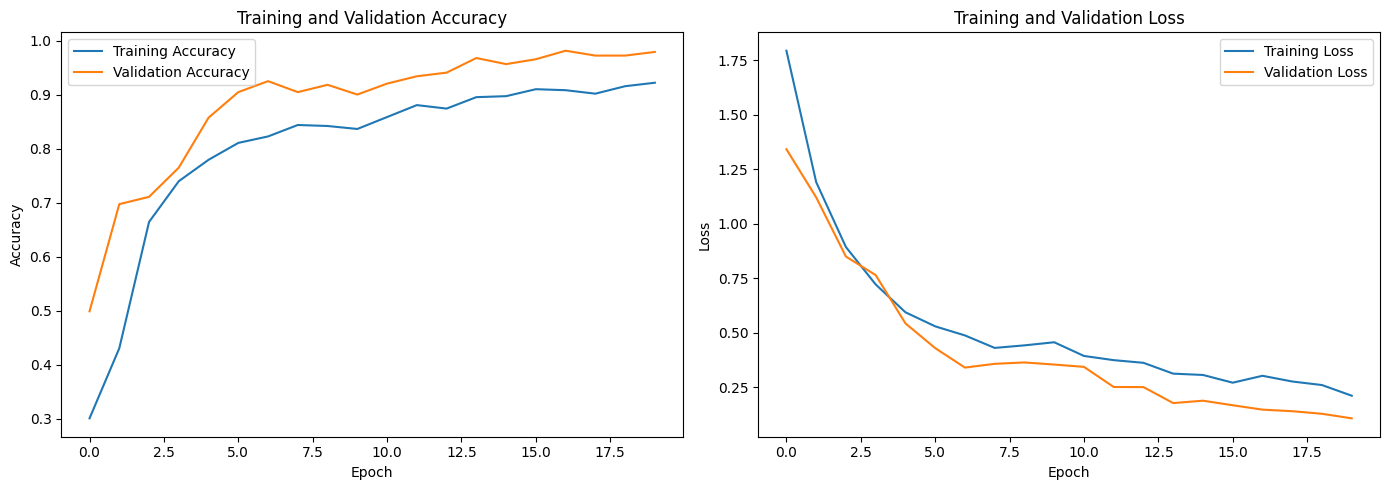

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step


<Figure size 800x600 with 0 Axes>

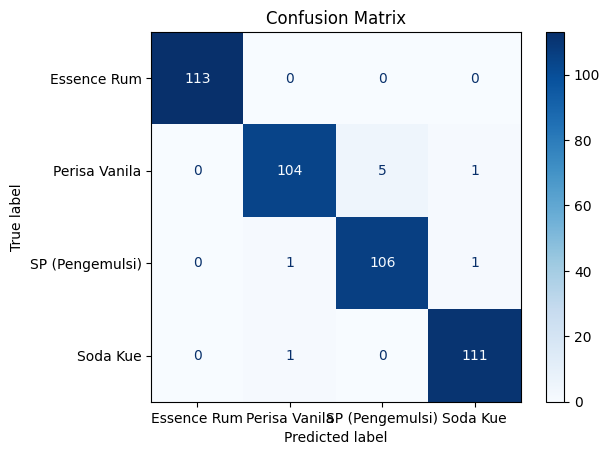

Classification Report:
                 precision    recall  f1-score   support

    Essence Rum       1.00      1.00      1.00       113
  Perisa Vanila       0.98      0.95      0.96       110
SP (Pengemulsi)       0.95      0.98      0.97       108
       Soda Kue       0.98      0.99      0.99       112

       accuracy                           0.98       443
      macro avg       0.98      0.98      0.98       443
   weighted avg       0.98      0.98      0.98       443



In [8]:
# ===== VISUALISASI GRAFIK AKURASI & LOSS =====
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ambil data dari training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot akurasi dan loss
plt.figure(figsize=(14, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ===== CONFUSION MATRIX & CLASSIFICATION REPORT =====

# Pastikan val_gen tidak shuffle untuk valid label urutan sama
y_true = val_gen.classes

# Prediksi
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Nama kelas
class_names = list(val_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Saving IMG_20250415_164117.jpg to IMG_20250415_164117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


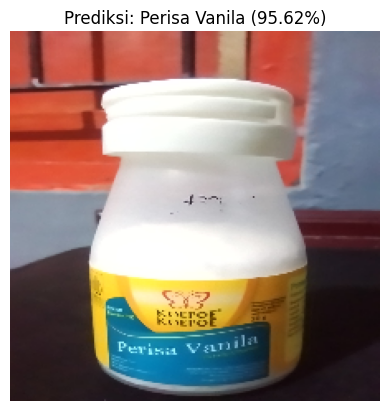

In [9]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# === UPLOAD GAMBAR BARU ===
uploaded = files.upload()

for file_name in uploaded.keys():
    # Load gambar dan preprocessing
    img_path = file_name
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize seperti val_gen
    img_array = np.expand_dims(img_array, axis=0)  # tambah batch dimensi

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_name = class_names[predicted_class]
    confidence = np.max(prediction) * 100

    # Tampilkan gambar + prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {class_name} ({confidence:.2f}%)")
    plt.show()
